In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

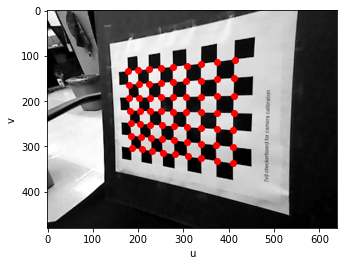

In [2]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------
ret, corners = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y))

if ret:
    ax.plot(corners[:, 0, 0], corners[:, 0, 1], 'ro')

# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [5]:
# --------- YOUR CODE STARTS HERE ---------------
objp = np.zeros((ncorners_y * ncorners_x, 3), np.float32)
objp[:, :2] = np.mgrid[0:ncorners_x, 0:ncorners_y].T.reshape(-1, 2)
objp *= SQUARE_SIZE  # Scale by the square size

# Since H is a homography between the world plane and image plane, we can ignore the Z coordinate
P = objp[:, :2]  # Shape (63, 2)
P_homog = np.hstack((P, np.ones((P.shape[0], 1))))  # Shape (63, 3)

# 1.b) Form the M matrix for homography estimation
M = []
for i in range(P_homog.shape[0]):
    X, Y, _ = P_homog[i]
    u, v = corners[i, 0]
    M.append([-X, -Y, -1, 0, 0, 0, u*X, u*Y, u])
    M.append([0, 0, 0, -X, -Y, -1, v*X, v*Y, v])
M = np.array(M)  # Shape (126, 9)

# 1.c) Use SVD to solve for the nullspace of M and recover H.
U, S, Vt = np.linalg.svd(M)
H = Vt[-1].reshape(3, 3)  # Homography matrix

# Normalize H to ensure H[2,2] is 1
H /= H[2, 2]

# 2) Compute the camera pose rotation, R, and translation, t.
#    2.a) Compute KinvH = inv(K) @ H.
K_inv = np.linalg.inv(K)
KinvH = K_inv @ H

#    2.b) Normalize the values of KinvH to its first column.
lambda_ = 1 / np.linalg.norm(KinvH[:, 0])
r0 = lambda_ * KinvH[:, 0]
r1 = lambda_ * KinvH[:, 1]
r2 = np.cross(r0, r1)
t = lambda_ * KinvH[:, 2]

#    2.c) Ensure R is a valid rotation matrix using Gram-Schmidt orthogonalization
#        Alternatively, use SVD to find the closest orthogonal matrix
R_approx = np.column_stack((r0, r1, r2))
U_r, S_r, Vt_r = np.linalg.svd(R_approx)
R = U_r @ Vt_r

#    2.d) Form R from r0, r1, and r2.
# (Already done above, ensuring R is orthogonal)

# Print the results
#print("Homography H:")
#print(H)
print("\nRotation R:")
print(R)
print("\nTranslation t:")
print(t)

# --------- YOUR CODE ENDS HERE -----------------


Rotation R:
[[-0.84160491 -0.02423809  0.53954952]
 [-0.04646736 -0.99203878 -0.11704631]
 [ 0.53809103 -0.1235782   0.83377843]]

Translation t:
[0.06041667 0.05504642 0.24836524]


## Problem 1.3

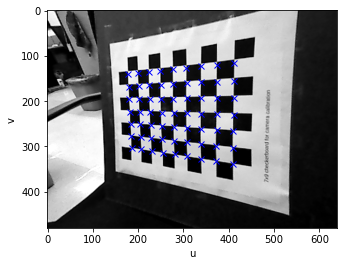

In [6]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------
    p_camera = (R @ world_coords.T).T + t  # Shape (N, 3)
    
    p_image_homog = (K @ p_camera.T).T  # Shape (N, 3)
    
    uv = p_image_homog[:, :2] / p_image_homog[:, 2].reshape(-1, 1)  # Shape (N, 2)
    
    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------
projected_uv = transform_world_to_camera(K, R, t, objp)
ax.plot(projected_uv[:, 0], projected_uv[:, 1], 'bx', label='Projected Points')
# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

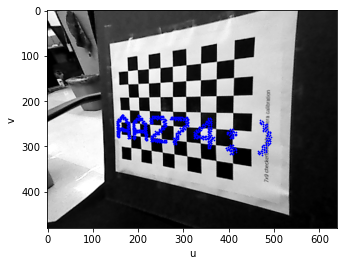

In [8]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")